[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/awsaf49/gcvit-tf/blob/main/notebooks/GCViT_Flower_Classification.ipynb)

# Installation

In [1]:
!pip install -qU gcvit --no-deps
!pip install -q tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.1 MB/s eta 0:00:00


Extracting Frames from Video:

In [5]:
!pip install opencv-contrib-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 17.6 MB/s eta 0:00:00


In [6]:
import cv2
import numpy as np

# from google.colab import drive
# drive.mount('/content/Traffic_accident_36.mp4')

video_path = '/content/Traffic_accident_36.mp4'

def extract_frames_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)  # store the frame
    cap.release()
    return np.array(frames)


Preprocessing Frames:

In [8]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [9]:
import tensorflow as tf

def preprocess_frame(frame, target_size=(224, 224)):
    frame_resized = cv2.resize(frame, target_size)  # Resize frame to target size
    frame_normalized = frame_resized / 255.0  # Normalize the frame values between 0 and 1
    return tf.convert_to_tensor(frame_normalized, dtype=tf.float32)


Adapting GC-ViT for Video:

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assume gcvit_model is the pretrained GC-ViT model
def build_video_anomaly_model(gcvit_model, input_shape=(10, 224, 224, 3)):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))  # Temporal modeling
    model.add(Dense(1, activation='sigmoid'))  # For binary anomaly detection (normal vs abnormal)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.reset_classifier(num_classes=104, head_act='softmax')
    return model


Anomaly Detection:

In [11]:
def calculate_anomaly_score(normal_frames, anomalous_frames, model):
    normal_features = model.predict(normal_frames)
    anomalous_features = model.predict(anomalous_frames)
    # Calculate anomaly score (e.g., mean squared error between normal and anomalous features)
    anomaly_score = np.mean(np.square(normal_features - anomalous_features), axis=1)
    return anomaly_score


## Imports

In [13]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## TPU/GPU detection

In [14]:
try:  # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # detect GPUss
    strategy = (
        tf.distribute.get_strategy()
    )  # default strategy that works on CPU and single GPU
print("Number of Accelerators: ", strategy.num_replicas_in_sync)

Number of Accelerators:  1


## Configuration

In [17]:
# Model
IMAGE_SIZE = [224, 224]

BATCH_SIZE = 32  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

# Data Pipeline

In [18]:
def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO)

# Flower Dataset

In [19]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=True,  # gcs_path is necessary for tpu,
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 3303
Number of validation examples: 367


## Prepare dataset

In [20]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

## Visualize

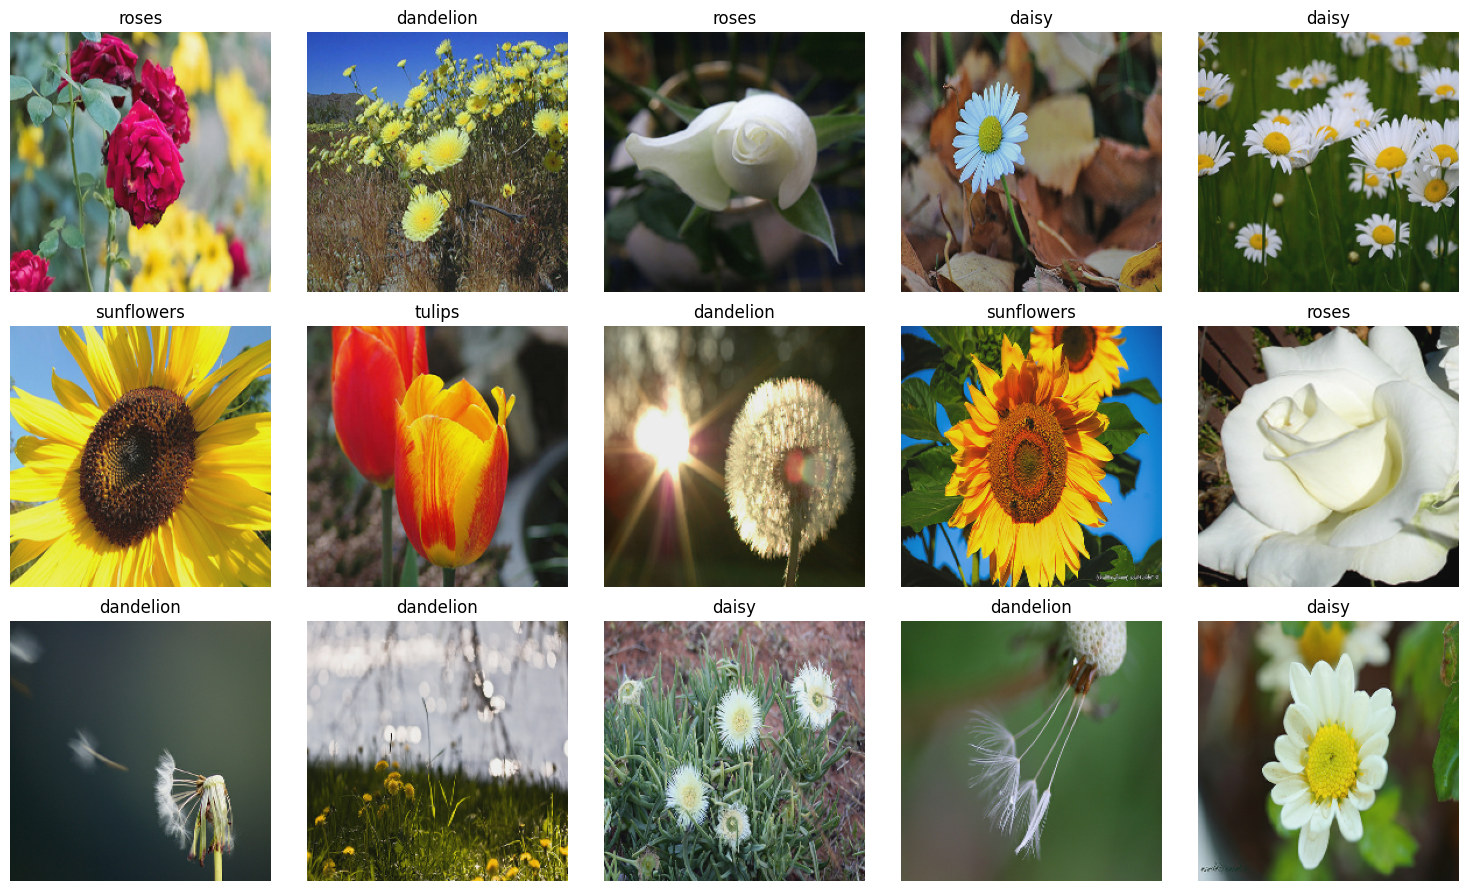

In [21]:
sample_images, sample_labels = next(iter(train_dataset))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n] * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(CLASSES[sample_labels[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()


# LR Scheduler Utility

In [22]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

# Training Hyperparameters

In [23]:
EPOCHS = 10
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)

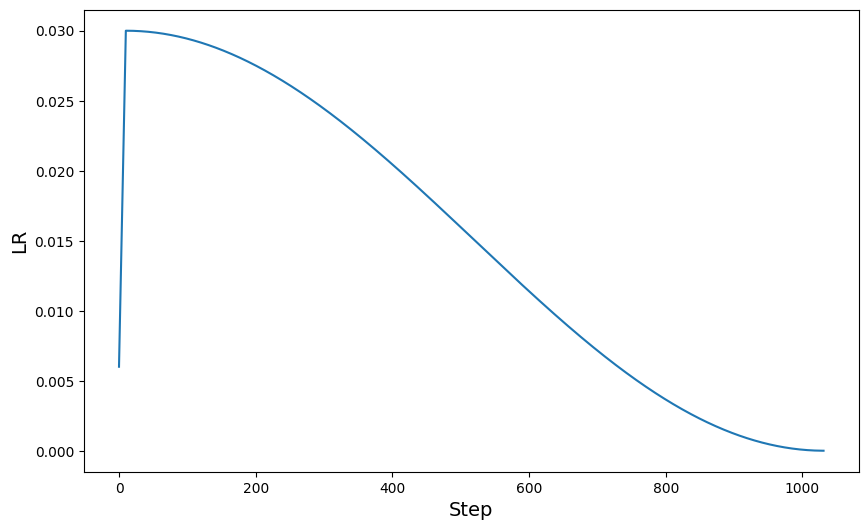

In [24]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()


In [25]:
optimizer = keras.optimizers.SGD(scheduled_lrs)
loss = keras.losses.SparseCategoricalCrossentropy()

# Building GCViT

<h1 align="center">
<p><a href='https://arxiv.org/pdf/2206.09959v1.pdf'>GCViT: Global Context Vision Transformer</a></p>
</h1>
<div align=center><img src="https://raw.githubusercontent.com/awsaf49/gcvit-tf/main/image/lvg_arch.PNG" width=800></div>
<p align="center">
<a href="https://github.com/awsaf49/gcvit-tf/blob/main/LICENSE.md">
  <img src="https://img.shields.io/badge/License-MIT-yellow.svg">
</a>
<img alt="python" src="https://img.shields.io/badge/python-%3E%3D3.6-blue?logo=python">
<img alt="tensorflow" src="https://img.shields.io/badge/tensorflow-%3E%3D2.4.1-orange?logo=tensorflow">
<div align=center><p>
<a target="_blank" href="https://huggingface.co/spaces/awsaf49/gcvit-tf"><img src="https://img.shields.io/badge/🤗%20Hugging%20Face-Spaces-yellow.svg"></a>
<a href="https://colab.research.google.com/github/awsaf49/gcvit-tf/blob/main/notebooks/GCViT_Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<a href="https://www.kaggle.com/awsaf49/flower-classification-gcvit-global-context-vit"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"></a>
</p></div>

In [31]:
from gcvit import GCViTTiny

with strategy.scope():
    model = GCViTTiny(input_shape=(*IMAGE_SIZE,3), pretrain=True)


model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["accuracy"])

# Saving Checkpoint

In [34]:
# ckpt_path = 'model.h5'
# ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=ckpt_path,
#     save_best_only=True,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     verbose=1)

ckpt_path = 'model.weights.h5'  # Update the file extension to .weights.h5
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


# Training & Validation

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    callbacks=[ckpt_callback])

Epoch 1/10
  3/103 ━━━━━━━━━━━━━━━━━━━━ 3:23:09 122s/step - accuracy: 0.0000e+00 - loss: 8.6548

## Training History

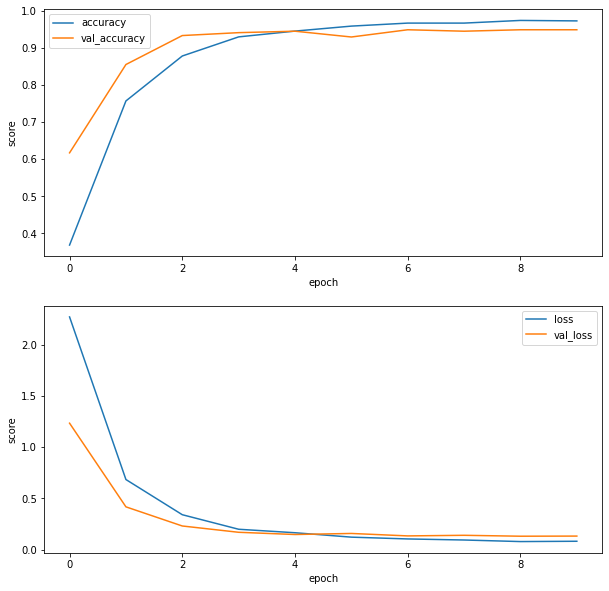

In [ ]:
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])


# Predictions

In [ ]:
sample_images, sample_labels = next(iter(val_dataset))

predictions = model.predict(sample_images, batch_size=16).argmax(axis=-1)
evaluations = model.evaluate(sample_images, sample_labels, batch_size=16)

print("[val_loss, val_acc]", evaluations)

8/8 [==============================] - 29s 74ms/step - loss: 0.1254 - accuracy: 0.9453
[val_loss, val_acc] [0.12536336481571198, 0.9453125]


## Visualize

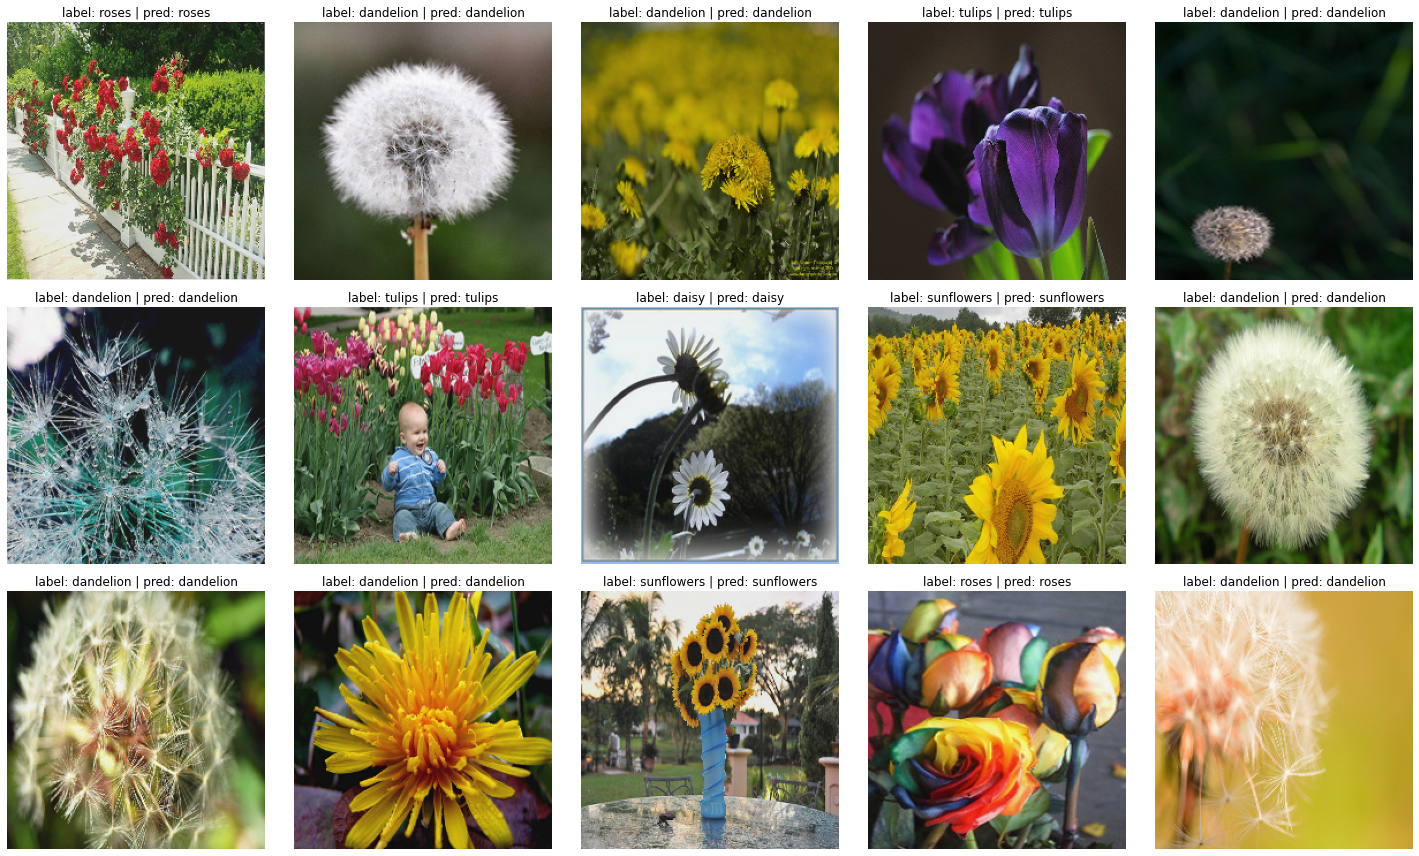

In [ ]:
plt.figure(figsize=(5 * 4, 3 * 4))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    image = (sample_images[i] * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    target = CLASSES[sample_labels[i]]
    pred = CLASSES[predictions[i]]
    plt.title("label: {} | pred: {}".format(target, pred), fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()


# Grad-CAM

In [ ]:
from gcvit.utils import get_gradcam_model, get_gradcam_prediction
from tqdm import tqdm

In [ ]:
gradcam_model = get_gradcam_model(model) # make gradcam model

In [ ]:
# Generate Grad-CAM heatmaps
heatmaps = []
for i in tqdm(range(15)):
  pred, heatmap = get_gradcam_prediction(sample_images[i].numpy(), gradcam_model, process=False, decode=False)
  heatmaps.append(heatmap)

100%|██████████| 15/15 [02:30<00:00, 10.04s/it]


## Visualize

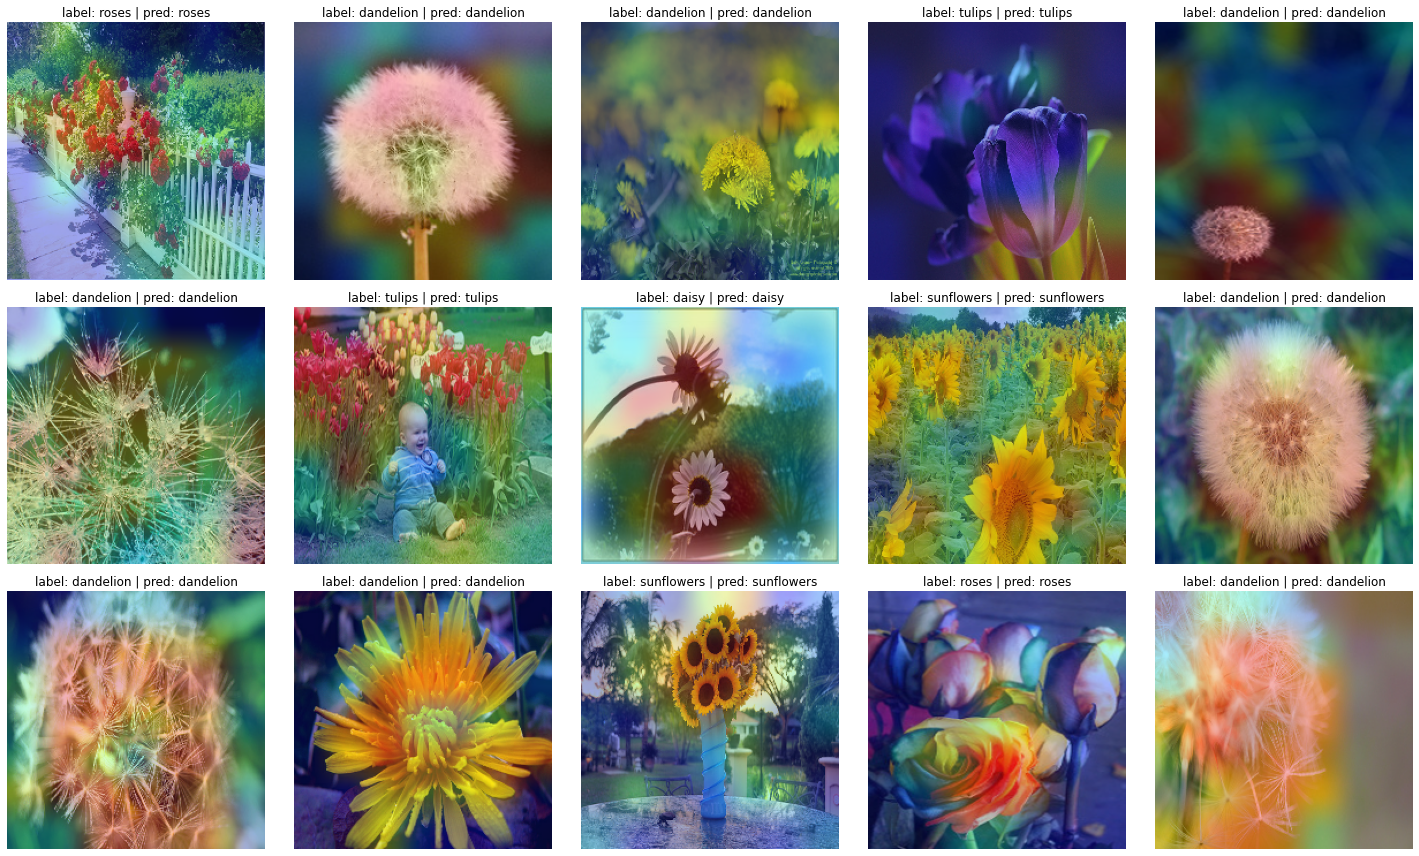

In [ ]:
plt.figure(figsize=(5 * 4, 3 * 4))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(heatmaps[i])
    target = CLASSES[sample_labels[i]]
    pred = CLASSES[predictions[i]]
    plt.title("label: {} | pred: {}".format(target, pred), fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Reference
* [gcvit](https://github.com/awsaf49/gcvit-tf)
* [Keras Flowers on TPU (solution)](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_solution.ipynb)